In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import optuna
import xgboost as xgb
import pickle

# **Modeling**

## Final Data Preparation

In [2]:
# Load in the modeling data
df = pd.read_csv('../data/Modeling_Data.csv',na_filter=False,
                 parse_dates=True)
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df.head(3)

,restaurant_id,inspection_id,score,grade,is_chain,cuisine_group,inspection_date,closed_past_two_years,avg_violations_past_two_years,violations_last_inspection,...,avg_critical_violations_past_two_years,inspection_risk_area,latitude,longitude,borough,inspection_type1,inspection_type2,log_avg_score_past_two_years,log_last_score,log_description_keywords_past_two_years
0,30075445,19604,21.0,Not A,No,Other,2023-01-31,0.0,-1.0,-1.0,...,-1.0,0.0,40.848231,-73.855972,Bronx,Cycle Inspection,Initial Inspection,-1.000000,-1.000000,-1.000000
1,30075445,19949,13.0,A,No,Other,2023-02-03,1.0,8.0,8.0,...,5.0,0.0,40.848231,-73.855972,Bronx,Cycle Inspection,Other,3.044522,3.044522,1.791759
2,30075445,31067,38.0,Not A,No,Other,2023-08-01,1.0,5.0,2.0,...,3.0,0.0,40.848231,-73.855972,Bronx,Cycle Inspection,Initial Inspection,2.833213,2.564949,2.079442


Since there is a temporal element to our data, let's first inspect a few elements of our data when grouped by time to figure out how best to split it on time.  First, let's examine if there are any particular years in which there are more novel restaurant IDs (which will equate to nulls in our window function columns) than other years.  Let's look at the proportion of these by year.

In [3]:
# Obtain an indicator for if the last grade is missing based on null values
copy = df.copy()
copy.loc[copy['last_grade']=='NULL','last_grade'] = np.nan
copy['last_grade_missing'] = copy['last_grade'].\
    apply(lambda x: 1 if pd.isna(x) else 0)
# Extract the inspection year from the inspection date
copy['inspection_year'] = copy['inspection_date'].dt.year
# Obtain the proportion of restaurants missing a previous inspection per year
missings = copy.groupby('inspection_year').agg(
    num_missing=('last_grade_missing',sum),
    num_total=('last_grade',np.size)
)
missings['prop_missing'] = missings['num_missing'] / missings['num_total']
# Add in the proportion of total inspections comprised by those in each year
missings['prop_observations'] = missings['num_total'] / copy.shape[0]
missings

C:\Users\seanm\AppData\Local\Temp\ipykernel_11632\218324139.py:9: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  missings = copy.groupby('inspection_year').agg(


,num_missing,num_total,prop_missing,prop_observations
inspection_year,,,,
2014,1,5,0.200000,0.000062
2015,5,8,0.625000,0.000099
2016,75,93,0.806452,0.001151
2017,88,169,0.520710,0.002092
2018,43,235,0.182979,0.002908
2019,66,293,0.225256,0.003626
2020,52,109,0.477064,0.001349
2021,1207,1356,0.890118,0.016783
2022,11448,15556,0.735922,0.192530


In [4]:
# Calculate the proportion of total inspections that are missing a previous record
missings['num_missing'].sum() / copy.shape[0]

0.32338671749300724

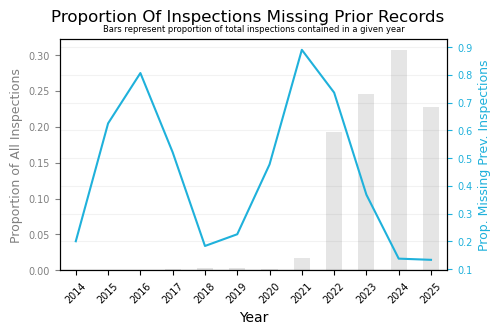

In [5]:
# Generate a lineplot to see the proportion of inspections missing a previous record by year
fig,ax1 = plt.subplots(figsize=(5,3))
missings['prop_observations'].plot(kind='bar',ax=ax1,color='gray',alpha=0.2)
plt.suptitle('Proportion Of Inspections Missing Prior Records')
plt.title('Bars represent proportion of total inspections contained in a given year',
          fontsize=6)
plt.xlabel('Year')
plt.xticks(rotation=45,size=7)
ax1.yaxis.label.set_color('gray')
ax1.tick_params(axis='y',colors='gray',which='both',labelsize=7)
ax1.set_ylabel('Proportion of All Inspections',color='gray',fontsize=9)
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(),missings['prop_missing'],color='#1fb1db')
ax2.yaxis.label.set_color('#1fb1db')
ax2.tick_params(axis='y',colors='#1fb1db',which='both',labelsize=7)
ax2.set_ylabel('Prop. Missing Prev. Inspections',
               color='#1fb1db',fontsize=9)
ax2.yaxis.grid(True,alpha=.1,color='gray')
plt.show()

While we do see a larger proportion of inspections missing previous records in the early years (when we start to get a higher volume of inspections in 2016), we also see a similar pattern in 2021-2022.  This would be surprising except for the fact that the number of total inspections recorded in these years is much greater.  Thus, it looks like many of the restaurants, even if they had prior inspections (since we have removed new restaurants), may not have them included in this dataset for years prior to 2021-2022.  Let's first see how many unique restaurant IDs there are in our data for each year to verify the pattern.

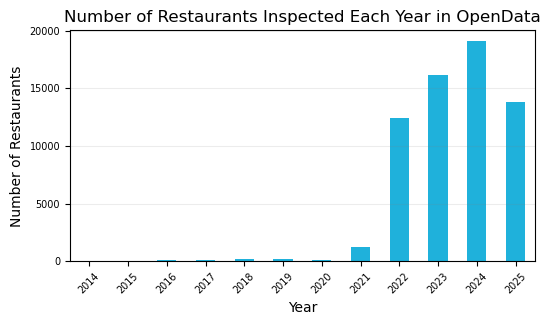

In [6]:
# Count the number of unique restaurants with inspections in each year and graph
plt.figure(figsize=(6,3))
copy.groupby('inspection_year')['restaurant_id']\
    .nunique().plot(kind='bar',color='#1fb1db')
plt.title('Number of Restaurants Inspected Each Year in OpenData')
plt.xlabel('Year')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45,size=7)
plt.yticks(size=7)
plt.gca().yaxis.grid(True,alpha=.15,color='gray')
plt.show()

We see clearly that many restaurants simply didn't have their inspection results recorded in this data prior to 2022.  This is a data quality problem that cannot be overcome here, unfortunately.  It's simply not the case that the number of restaurants in NYC increased tenfold from 2021 to 2022.  After 2022, things look pretty stable and believable.  The problem here is that, if a restaurant's missing previous inspection data actually carries some kind of signal for its future inspection grade, we will likely miss out on it due to all these "false alarms".  Instead, we want restaurants that are missing prior inspection data to be missing it genuinely, because it was the first inspection conducted for that restaurant.  Ideally, then, we would remove all these "false alarms" - restaurants missing prior inspection data even though they likely did have prior inspections.  Most of these would likely simply be due to the fact that the past inspection data was not comprehensively included for all these restaurants before 2022.  Before we remove all these rows, however, let us see how much of our data we would be removing.

In [7]:
# See what proportion of rows we would be removing from our dataset
rows_to_remove = df.loc[df['last_grade']=='NULL']\
    .shape[0]
total = df.shape[0]
rows_to_remove/total

0.32338671749300724

This is a hefty proportion, but it is likely worth it to ensure a valid signal.  In years going forward, this will be a smaller and smaller portion of the dataset, since hopefully there will be more comprehensive data collection for all NYC restaurants. Let's go ahead and remove these for now, and then we can split our data on time. 

In [8]:
# Remove "false alarm" rows from early years
df = df.loc[df['last_grade']!='NULL']
print(f'{len(df)} inspections remaining in the data')  # print number of remaining inspections

54669 inspections remaining in the data


In [9]:
# Let's now take a quick peek at how we should divide 2025 observations into val and oot
final_yr = df.loc[df['inspection_date'].dt.year==2025]
final_yr['inspection_month'] = final_yr['inspection_date'].dt.month
final_yr['inspection_month'].value_counts(normalize=True).sort_index()

C:\Users\seanm\AppData\Local\Temp\ipykernel_20984\2553804858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_yr['inspection_month'] = final_yr['inspection_date'].dt.month


inspection_month
1    0.128980
2    0.096452
3    0.102355
4    0.095761
5    0.122449
6    0.105118
7    0.124961
8    0.125777
9    0.098148
Name: proportion, dtype: float64

Since it looks like each month in 2025 has a roughly equal number of inspections, we will make the first six months our validation set and the last three months (through September) our out-of-time set.  The rest will be the training data.

In [10]:
# Send the inspection ID column to be the index
df.set_index('inspection_id',inplace=True)
# Split the data into train, validation, and out-of-time
train = df.loc[df['inspection_date'].dt.year<2025]
val = df.loc[(df['inspection_date'].dt.year==2025) & (df['inspection_date'].dt.month<7)]
oot = df.loc[(df['inspection_date'].dt.year==2025) & (df['inspection_date'].dt.month>6)]

In [11]:
# Print out the proportion of the data in each partition
total = len(df)
t_size = len(train)
v_size = len(val)
oot_size = len(oot)
print(f'Proportion of data in train: {np.round(t_size/total,2)}')
print(f'Proportion of data in validation: {np.round(v_size/total,2)}')
print(f'Proportion of data in out-of-time: {np.round(oot_size/total,2)}')

Proportion of data in train: 0.71
Proportion of data in validation: 0.19
Proportion of data in out-of-time: 0.1


In [12]:
# Split each into features and labels
X_train = train.drop('grade',axis=1)
X_val = val.drop('grade',axis=1)
X_oot = oot.drop('grade',axis=1)
y_train = train['grade']
y_val = val['grade']
y_oot = oot['grade']

In [13]:
# Encode the response as 0 for 'A' and 1 for 'Not A'
y_train = y_train.apply(lambda x: 0 if x=='A' else 1)
y_val = y_val.apply(lambda x: 0 if x=='A' else 1)
y_oot = y_oot.apply(lambda x: 0 if x=='A' else 1)

## Dropping Final Features

Before actually fitting models, we will have to remove a few features that are superfluous to our modeling.  These will be things like unique identifiers (inspection_id will be the index so we can pull these things back in after modeling), superfluous geographic features, and any raw features we have generated engineered versions of.

In [14]:
# Remove superfluous columns before modeling
cols_to_remove = ['restaurant_id',
                  'score',
                  'inspection_date',
                  'latitude',
                  'longitude']
for partition in [X_train,X_val,X_oot]:
    partition.drop(cols_to_remove,axis=1,inplace=True)

In [15]:
# Ensure appropriate columns were removed
X_train.head(3)

,is_chain,cuisine_group,closed_past_two_years,avg_violations_past_two_years,violations_last_inspection,last_grade,days_since_last,avg_critical_violations_past_two_years,inspection_risk_area,borough,inspection_type1,inspection_type2,log_avg_score_past_two_years,log_last_score,log_description_keywords_past_two_years
inspection_id,,,,,,,,,,,,,,,
19949,No,Other,1.0,8.000000,8.0,Not A,3.0,5.000000,0.0,Bronx,Cycle Inspection,Other,3.044522,3.044522,1.791759
31067,No,Other,1.0,5.000000,2.0,A,179.0,3.000000,0.0,Bronx,Cycle Inspection,Initial Inspection,2.833213,2.564949,2.079442
31890,No,Other,1.0,4.333333,3.0,Not A,21.0,2.666667,0.0,Bronx,Cycle Inspection,Re-inspection,3.178054,3.637586,2.890372


## Dummy Variables

The last step before modeling will be getting dummy variables for our data.  Let's do that here.  We will also reserve a version of each split without dummy variables for reference later, and we will do a final check of how imbalanced our dataset is.

In [16]:
# Reserve a version of each split before dummy variables were created
X_train_reserve = X_train.copy()
X_val_reserve = X_val.copy()
X_oot_reserve = X_oot.copy()
df['grade'].value_counts(normalize=True)

grade
A        0.620132
Not A    0.379868
Name: proportion, dtype: float64

In [17]:
# Create dummy variables and check that this was done properly
cols_before = X_train.shape[1]
X_train = pd.get_dummies(X_train,drop_first=True,dtype='int')
X_val = pd.get_dummies(X_val,drop_first=True,dtype='int')
X_oot = pd.get_dummies(X_oot,drop_first=True,dtype='int')
cols_after = X_train.shape[1]
# Check if all the columns are the same
if set(X_train.columns)==set(X_val.columns) and set(X_val.columns)==set(X_oot.columns):
    print('All partitions have the same columns')
print(f'Columns before: {cols_before}\nColumns after: {cols_after}')

All partitions have the same columns
Columns before: 15
Columns after: 28


Excellent!  Now we are ready to build the models with sci-kit learn, the xgboost library, and optuna.

## Building the Models

### **Logistic Regression**

We will begin by scaling the X features.  This will mostly be for the sake of logistic regression, but for consistency's sake, we will use the same X matrices for each of our tree-based methods as well.

In [18]:
from sklearn.preprocessing import MinMaxScaler
# Use MinMaxScaler() on each X matrix
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              index=X_train.index,
                              columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),
                            index=X_val.index,
                            columns=X_val.columns)
X_oot_scaled = pd.DataFrame(scaler.transform(X_oot),
                            index=X_oot.index,
                            columns=X_oot.columns)

#### *Recursive Feature Elimination*

Since we know that many of the features are highly correlated with each other, let's try a recursive feature selection algorithm to see if there is an optimal, reduced feature set that we can feed to optuna for training.  We will iterate through smaller and smaller feature numbers until we identify and optimal feature set.  This will be judged by looking at a plot.  Model performance will be assessed by calculating a weighted f1 score, called the `fbeta` score in `sci-kit learn`.  This is essentially an f1 score that puts, for our purposes, more importance on recall than precision.  While calculating the harmonic mean between the two metrics, we will have the `fbeta` score treat recall as twice as important as precision (beta=2) since it is most important for our model to reliably detect at-risk restaurants.  There is more cost when failing to detect at-risk restaurants than when failing to detect compliant restaurants.  The parameters passed to our logistic regression model come from a preliminary optuna tuning round.  The model will be re-tuned after features are selected here.

In [19]:
from sklearn.feature_selection import RFE
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression

# Specify params
params = {
    'C':78.21650535020736,
    'max_iter':224,
    'l1_ratio':0.3341754035940826,
    'solver':'saga',
    'penalty':'elasticnet',
    'random_state':121,
    'verbose':0
}

# Grab the number of features we begin with
all_features = X_train_scaled.shape[1]
# Make a list from this number down to 1
feat_list = list(range(1,all_features+1))[::-1]
# Grab a copy of the original feature set to pass in for train and val
X_train_scaled_lr = X_train_scaled.copy()
X_val_scaled_lr = X_val_scaled.copy()
# Initialize dict to store results
rfe_results = {
    'Num Features':[],
    'Val Fbeta':[],
    'X_train_matrix':[],
    'X_val_matrix':[]
}

# Run RFE for each number of features and record the fbeta score on validation data
for num in feat_list:
    estimator = LogisticRegression(**params)
    selector = RFE(estimator,n_features_to_select=num,step=1)
    selector.fit(X_train_scaled_lr,y_train)

    # Calculate fbeta on validation data and store results
    preds = selector.predict(X_val_scaled_lr)
    rfe_results['Num Features'].append(num)
    rfe_results['Val Fbeta'].append(fbeta_score(y_val,preds,beta=2))  # recall 2x more important

    # Subset to the cols selected by the algorithm and store results
    support = selector.support_
    X_train_scaled_lr = X_train_scaled_lr.iloc[:,support]
    X_val_scaled_lr = X_val_scaled_lr.iloc[:,support]
    rfe_results['X_train_matrix'].append(X_train_scaled_lr.copy())
    rfe_results['X_val_matrix'].append(X_val_scaled_lr.copy())

    # Print a progress statement
    print(f'Finished iteration with {num} features.  Fbeta Score: {fbeta_score(y_val,preds,beta=2)}')

# After the loop runs, gather the results into a data frame for plotting
rfe_subset = {k: rfe_results[k] for k in {'Num Features','Val Fbeta'}}
rfe_data = pd.DataFrame(rfe_subset)

# Extract the final X train, val, and oot matrices
max_ind = pd.Series(rfe_results['Val Fbeta']).idxmax()
X_train_scaled_lr = rfe_results['X_train_matrix'][max_ind]
X_val_scaled_lr = rfe_results['X_val_matrix'][max_ind]
X_oot_scaled_lr = X_oot_scaled[list(X_train_scaled_lr.columns)]
# Double check number of features
if rfe_results['Num Features'][max_ind] == X_train_scaled_lr.shape[1]:
    print('Final X matrices have correct number of features.')


Finished iteration with 28 features.  Fbeta Score: 0.37186636785323396
Finished iteration with 27 features.  Fbeta Score: 0.37186636785323396
Finished iteration with 26 features.  Fbeta Score: 0.3716251433336808
Finished iteration with 25 features.  Fbeta Score: 0.3725316521648518
Finished iteration with 24 features.  Fbeta Score: 0.37275332117738996
Finished iteration with 23 features.  Fbeta Score: 0.3713258286429018
Finished iteration with 22 features.  Fbeta Score: 0.3706213511259383
Finished iteration with 21 features.  Fbeta Score: 0.37298649846218007
Finished iteration with 20 features.  Fbeta Score: 0.3766409668680975
Finished iteration with 19 features.  Fbeta Score: 0.37271778821074597
Finished iteration with 18 features.  Fbeta Score: 0.3698773166275124
Finished iteration with 17 features.  Fbeta Score: 0.36234160645093727
Finished iteration with 16 features.  Fbeta Score: 0.3557727678806033
Finished iteration with 15 features.  Fbeta Score: 0.35481497056349875
Finished iter

In [20]:
# Define a function to plot the RFE results
def plot_rfe(
    data:pd.DataFrame,
    model_type:str,
    figsize=(4,3),
    feat_col:str='Num Features',
    fbeta_col:str='Val Fbeta'
):
    
    # Extract the maximum fbeta score and number of features for it
    best_num = int(data.loc[data[fbeta_col].argmax()][feat_col])
    best_fbeta = data.loc[data[fbeta_col].argmax()][fbeta_col]

    # Create the lineplot
    fig,ax = plt.subplots(figsize=figsize)
    sns.lineplot(data=data,
                x=feat_col,
                y=fbeta_col,
                color='#1fb1db',
                ax=ax)
    plt.title(f'Recursive Feature Selection for {model_type}',fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('Val Weighted F1 Score',fontsize=8)
    plt.xlabel(feat_col,fontsize=8)
    ax.invert_xaxis()  # Want to sort X axis in descending order
    plt.gca().xaxis.grid(True,alpha=.2)
    plt.gca().yaxis.grid(True,alpha=.2)

    # Add label for the best number of features
    plt.annotate(text=f'Best at {best_num} feats',
                 xy=(best_num,best_fbeta),
                 xytext=(best_num+4,best_fbeta-.08),
                 fontsize=7,
                 color='#1fb1db',
                 fontweight='bold',
                 arrowprops=dict(facecolor='#1fb1db',
                                 arrowstyle='->'))

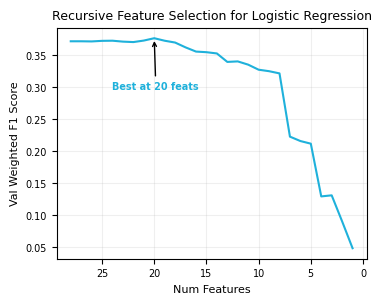

In [21]:
# Plot the results of recursive feature selection
plot_rfe(data=rfe_data,model_type='Logistic Regression')

#### *Fitting the Model*

Excellent, we now have a reduced feature set of 20 features to pass to our model.  Now, let's define our objective function and train the model, using optuna for hyperparameter tuning.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
# Define the optuna objective function for hyperparameter tuning
def objective(trial):
    # Specify parameters to tune
    tune_params = {
        'C':trial.suggest_float('C',low=0.01,high=100,log=True),
        'max_iter':trial.suggest_int('max_iter',low=50,high=200),
        'l1_ratio':trial.suggest_float('l1_ratio',low=0,high=1,log=False)  # L1/L2 ratio
    }

    # Fit the model
    model = LogisticRegression(**tune_params,
                               solver='saga',
                               penalty='elasticnet',
                               random_state=121,
                               verbose=0)
    model.fit(X_train_scaled_lr,y_train)
    y_pred = model.predict(X_val_scaled_lr)
    
    # Obtain weighted F1 metric
    score = fbeta_score(y_val,y_pred,beta=2)

    # Return the weighted F1 score as the metric to maximize
    return score


In [23]:
# Create the optuna study and train the model
optuna.logging.set_verbosity(optuna.logging.WARNING)  # only print warnings and final results
study = optuna.create_study(study_name='logistic_regression_study',direction='maximize')
study.optimize(objective,n_trials=1000,show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
best_val = study.best_value
print(f'The best weighted F1 score was {best_val} using the following parameters:\n{best_params}')

  0%|          | 0/1000 [00:00<?, ?it/s]

The best weighted F1 score was 0.3766409668680975 using the following parameters:
{'C': 68.59324800816202, 'max_iter': 148, 'l1_ratio': 0.30035414274519445}


We will also take a look at the optuna study visualizations

In [24]:
import optuna.visualization as vis
# Hyperparameter importances
vis.plot_param_importances(study)

In [25]:
# Model optimization history across trials
vis.plot_optimization_history(study)

In [26]:
# Fit the final model using the best parameters and save it
lr = LogisticRegression(**best_params,
                        solver='saga',
                        penalty='elasticnet',
                        random_state=121,
                        verbose=1)
lr.fit(X_train_scaled_lr,y_train)
filepath = '../models/logistic_regression.sav'
pickle.dump(lr,open(filepath,'wb'))

convergence after 21 epochs took 1 seconds


The below cell can be used to load the already-trained model.

In [27]:
# Load the pre-trained logistic regression model
filepath = '../models/logistic_regression.sav'
lr = pickle.load(open(filepath,'rb'))

### **Random Forest**

Now, we will carry out a similar process for our tree-based methods to see if they yield a performance improvement over the baseline logistic regression model.  Let's start with our random forest model.  We will conduct recursive feature selection as before.

#### *Recursive Feature Elimination*

In [28]:
from sklearn.feature_selection import RFE
from sklearn.metrics import fbeta_score

# Specify params
params = {
    'max_depth':27,
    'colsample_bynode':0.8782619537985084,
    'num_parallel_tree': 228,
    'subsample':0.974475992536768,
    'learning_rate':1,  # for random forest
    'objective':'binary:logistic',
    'random_state':121
}

# Grab the number of features we begin with
all_features = X_train_scaled.shape[1]
# Make a list from this number down to 1
feat_list = list(range(1,all_features+1))[::-1]
# Grab a copy of the original feature set to pass in for train and val
X_train_scaled_rf = X_train_scaled.copy()
X_val_scaled_rf = X_val_scaled.copy()
# Initialize dict to store results
rfe_results = {
    'Num Features':[],
    'Val Fbeta':[],
    'X_train_matrix':[],
    'X_val_matrix':[]
}

# Run RFE for each number of features and record the weighted F1 score on validation data
for num in feat_list:
    estimator = xgb.XGBRFClassifier(**params)
    selector = RFE(estimator,n_features_to_select=num,step=1)
    selector.fit(X_train_scaled_rf,y_train)

    # Calculate fbeta score on validation data and store results
    preds = selector.predict(X_val_scaled_rf)
    rfe_results['Num Features'].append(num)
    rfe_results['Val Fbeta'].append(fbeta_score(y_val,preds,beta=2))

    # Subset to the cols selected by the algorithm and store results
    support = selector.support_
    X_train_scaled_rf = X_train_scaled_rf.iloc[:,support]
    X_val_scaled_rf = X_val_scaled_rf.iloc[:,support]
    rfe_results['X_train_matrix'].append(X_train_scaled_rf.copy())
    rfe_results['X_val_matrix'].append(X_val_scaled_rf.copy())

    # Print a progress statement
    print(f'Finished iteration with {num} features.  Fbeta score: {fbeta_score(y_val,preds,beta=2)}')

# After the loop runs, gather the results into a data frame for plotting
rfe_subset = {k: rfe_results[k] for k in {'Num Features','Val Fbeta'}}
rfe_data = pd.DataFrame(rfe_subset)

# Extract the final X train, val, and oot matrices
max_ind = pd.Series(rfe_results['Val Fbeta']).idxmax()
X_train_scaled_rf = rfe_results['X_train_matrix'][max_ind]
X_val_scaled_rf = rfe_results['X_val_matrix'][max_ind]
X_oot_scaled_rf = X_oot_scaled[list(X_train_scaled_rf.columns)]
# Double check number of features
if rfe_results['Num Features'][max_ind] == X_train_scaled_rf.shape[1]:
    print('Final X matrices have correct number of features.')


Finished iteration with 28 features.  Fbeta score: 0.4771225838023
Finished iteration with 27 features.  Fbeta score: 0.475606766364305
Finished iteration with 26 features.  Fbeta score: 0.47257218491102504
Finished iteration with 25 features.  Fbeta score: 0.4635191020086648
Finished iteration with 24 features.  Fbeta score: 0.4695238562251753
Finished iteration with 23 features.  Fbeta score: 0.47681045494743046
Finished iteration with 22 features.  Fbeta score: 0.4750184592665518
Finished iteration with 21 features.  Fbeta score: 0.47354171794240707
Finished iteration with 20 features.  Fbeta score: 0.47983514866058286
Finished iteration with 19 features.  Fbeta score: 0.4736143215462549
Finished iteration with 18 features.  Fbeta score: 0.4742820613690008
Finished iteration with 17 features.  Fbeta score: 0.4710947109471095
Finished iteration with 16 features.  Fbeta score: 0.46800334991871523
Finished iteration with 15 features.  Fbeta score: 0.4492429883345743
Finished iteration 

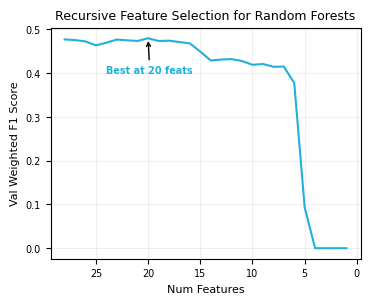

In [29]:
# Plot the results of recursive feature selection
plot_rfe(data=rfe_data,model_type='Random Forests')

#### *Fitting the Model*

In [30]:
from sklearn.metrics import fbeta_score
# Define the optuna objective function
def objective(trial):
    # Specify parameters to tune
    tune_params = {
        'max_depth':trial.suggest_int('max_depth',low=1,high=100),
        'colsample_bynode':trial.suggest_float('colsample_bynode',low=.5,high=1,log=False),
        'num_parallel_tree':trial.suggest_int('num_parallel_tree',low=100,high=300),
        'subsample':trial.suggest_float('subsample',low=.5,high=1,log=False)
    }

    # Fit the model
    model = xgb.XGBRFClassifier(**tune_params,
                                learning_rate=1,  # for random forest
                                objective='binary:logistic',
                                random_state=121)
    model.fit(X_train_scaled_rf,
              y_train,
              verbose=False)
    y_pred = model.predict(X_val_scaled_rf)
    
    # Obtain weighted F1 score
    score = fbeta_score(y_val,y_pred,beta=2)

    # Return the weighted F1 score as the metric to maximize
    return score

In [31]:
# Create the optuna study and train the model
optuna.logging.set_verbosity(optuna.logging.WARNING)  # only print warnings and final results
study = optuna.create_study(study_name='random_forest_study',direction='maximize')
study.optimize(objective,n_trials=1000,show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
best_val = study.best_value
print(f'The best weighted F1 score was {best_val} using the following parameters:\n{best_params}')

  0%|          | 0/1000 [00:00<?, ?it/s]

The best weighted F1 score was 0.48761344125582534 using the following parameters:
{'max_depth': 60, 'colsample_bynode': 0.7627622037358771, 'num_parallel_tree': 139, 'subsample': 0.9885080508852323}


We will also take a look at the optuna study visualizations just as before.

In [32]:
# Hyperparameter importances
vis.plot_param_importances(study)

In [33]:
# Model optimization history across trials
vis.plot_optimization_history(study)

In [34]:
# Fit the final model using the best parameters and save it
rf = xgb.XGBRFClassifier(**best_params,
                        learning_rate=1,  # for random forest
                        objective='binary:logistic',
                        random_state=121)
rf.fit(X_train_scaled_rf,y_train)
filepath = '../models/random_forest.sav'
pickle.dump(rf,open(filepath,'wb'))

In [35]:
# Load the pre-trained random forest model
filepath = '../models/random_forest.sav'
rf = pickle.load(open(filepath,'rb'))

### **Gradient Boosting**

And finally, we will tune and train our gradient boosting model.  Since the `xgboost` package supports early stopping for gradient boosting models, we will implement this with our validation set and tune the early stopping rounds.  This should help prevent overfitting.  We will begin with the recursive feature selection step as with the other two models.

#### *Recursive Feature Elimination*

In [36]:
from sklearn.feature_selection import RFE
from sklearn.metrics import fbeta_score

# Specify params
params = {
    'max_depth':73,
    'learning_rate':0.9929202544085219,
    'n_estimators':178,
    'subsample':0.8081814267820513,
    'colsample_bytree':0.6288072507330643,
    'min_child_weight':7,
    'gamma':4.429514541521986,
    'reg_alpha':0.47806038415967383,
    'objective':'binary:logistic',
    'random_state':121,
}

# Grab the number of features we begin with
all_features = X_train_scaled.shape[1]
# Make a list from this number down to 1
feat_list = list(range(1,all_features+1))[::-1]
# Grab a copy of the original feature set to pass in for train and val
X_train_scaled_gb = X_train_scaled.copy()
X_val_scaled_gb = X_val_scaled.copy()
# Initialize dict to store results
rfe_results = {
    'Num Features':[],
    'Val Fbeta':[],
    'X_train_matrix':[],
    'X_val_matrix':[]
}

# Run RFE for each number of features and record the accuracy on validation data
for num in feat_list:
    estimator = xgb.XGBClassifier(**params)
    selector = RFE(estimator,n_features_to_select=num,step=1)
    selector.fit(X_train_scaled_gb,
                 y_train)

    # Calculate accuracy on validation data and store results
    preds = selector.predict(X_val_scaled_gb)
    rfe_results['Num Features'].append(num)
    rfe_results['Val Fbeta'].append(fbeta_score(y_val,preds,beta=2))

    # Subset to the cols selected by the algorithm and store results
    support = selector.support_
    X_train_scaled_gb = X_train_scaled_gb.iloc[:,support]
    X_val_scaled_gb = X_val_scaled_gb.iloc[:,support]
    rfe_results['X_train_matrix'].append(X_train_scaled_gb.copy())
    rfe_results['X_val_matrix'].append(X_val_scaled_gb.copy())

    # Print a progress statement
    print(f'Finished iteration with {num} features.  Fbeta score: {fbeta_score(y_val,preds,beta=2)}')

# After the loop runs, gather the results into a data frame for plotting
rfe_subset = {k: rfe_results[k] for k in {'Num Features','Val Fbeta'}}
rfe_data = pd.DataFrame(rfe_subset)

# Extract the final X train, val, and oot matrices
max_ind = pd.Series(rfe_results['Val Fbeta']).idxmax()
X_train_scaled_gb = rfe_results['X_train_matrix'][max_ind]
X_val_scaled_gb = rfe_results['X_val_matrix'][max_ind]
X_oot_scaled_gb = X_oot_scaled[list(X_train_scaled_gb.columns)]
# Double check number of features
if rfe_results['Num Features'][max_ind] == X_train_scaled_gb.shape[1]:
    print('Final X matrices have correct number of features.')


Finished iteration with 28 features.  Fbeta score: 0.45422746352188687
Finished iteration with 27 features.  Fbeta score: 0.46392775627666966
Finished iteration with 26 features.  Fbeta score: 0.433654185355037
Finished iteration with 25 features.  Fbeta score: 0.44995984742019673
Finished iteration with 24 features.  Fbeta score: 0.4558376140840856
Finished iteration with 23 features.  Fbeta score: 0.4626724438468051
Finished iteration with 22 features.  Fbeta score: 0.4503400680136027
Finished iteration with 21 features.  Fbeta score: 0.4482551143200963
Finished iteration with 20 features.  Fbeta score: 0.4567919724427138
Finished iteration with 19 features.  Fbeta score: 0.44466800804828976
Finished iteration with 18 features.  Fbeta score: 0.44228640434738853
Finished iteration with 17 features.  Fbeta score: 0.4503284689835013
Finished iteration with 16 features.  Fbeta score: 0.44534819500928857
Finished iteration with 15 features.  Fbeta score: 0.4403037618185476
Finished iterat

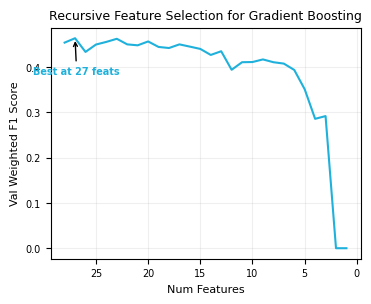

In [37]:
# Plot the results of recursive feature selection
plot_rfe(data=rfe_data,model_type='Gradient Boosting')

#### *Fitting the Model*

In [38]:
from sklearn.metrics import fbeta_score
# Define the optuna objective function
def objective(trial):
    # Specify parameters to tune
    tune_params = {
        'max_depth':trial.suggest_int('max_depth',low=1,high=150),
        'learning_rate':trial.suggest_float('learning_rate',low=0.01,high=100,log=True),
        'n_estimators':trial.suggest_int('n_estimators',low=10,high=200),
        'subsample':trial.suggest_float('subsample',low=.5,high=1,log=False),
        'colsample_bytree':trial.suggest_float('colsample_bytree',low=.4,high=1,log=False),
        'min_child_weight':trial.suggest_int('min_child_weight',low=1,high=30),
        'gamma':trial.suggest_float('gamma',low=0,high=10,log=False),
        'reg_alpha':trial.suggest_float('reg_alpha',low=0,high=1,log=False),  # L1 regularization
        'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',low=2,high=40)
    }

    # Fit the model
    model = xgb.XGBClassifier(**tune_params,
                              objective='binary:logistic',
                              random_state=121,
                              eval_metric='error')
    model.fit(X_train_scaled_gb,
              y_train,
              eval_set=[(X_val_scaled_gb,y_val)],
              verbose=False)
    y_pred = model.predict(X_val_scaled_gb)
    
    # Obtain weighted F1 score
    score = fbeta_score(y_val,y_pred,beta=2)

    # Return the weighted F1 score as the metric to maximize
    return score

In [39]:
# Create the optuna study and train the model
optuna.logging.set_verbosity(optuna.logging.WARNING)  # only print warnings and final results
study = optuna.create_study(study_name='gradient_boosting_study',direction='maximize')
study.optimize(objective,n_trials=1000,show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
best_val = study.best_value
print(f'The best weighted F1 score was {best_val} using the following parameters:\n{best_params}')

  0%|          | 0/1000 [00:00<?, ?it/s]

The best weighted F1 score was 0.676208433321906 using the following parameters:
{'max_depth': 140, 'learning_rate': 65.67632521268958, 'n_estimators': 149, 'subsample': 0.5503781031150271, 'colsample_bytree': 0.4000014372097397, 'min_child_weight': 27, 'gamma': 5.445999375692286, 'reg_alpha': 0.7102639184069104, 'early_stopping_rounds': 21}


We will also take a look at the optuna study visualizations just as before.

In [40]:
# Hyperparameter importances
vis.plot_param_importances(study)

In [41]:
# Model optimization history across trials
vis.plot_optimization_history(study)

In [42]:
# Fit the final model using the best parameters and save it
gb = xgb.XGBClassifier(**best_params,
                       objective='binary:logistic',
                       random_state=121,
                       eval_metric='error')
gb.fit(X_train_scaled_gb,
       y_train,
       eval_set=[(X_val_scaled_gb,y_val)],
       verbose=False)
filepath = '../models/gradient_boosting.sav'
pickle.dump(gb,open(filepath,'wb'))

In [43]:
# Load the pre-trained random forest model
filepath = '../models/gradient_boosting.sav'
gb = pickle.load(open(filepath,'rb'))

## Performance Metrics and Comparison

Using our final models, we will generate classification reports on each partition of data.

In [44]:
# Create a custom colormap for our plots below
import matplotlib.colors as mcolors
cmap_list = ['#4e5151','#1fb1db']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap',
                                                        colors=cmap_list,
                                                        N=100)

### *Logistic Regression*

**TRAIN**

In [45]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
# Classification report
y_pred = lr.predict(X_train_scaled_lr)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77     24604
           1       0.59      0.24      0.35     14140

    accuracy                           0.66     38744
   macro avg       0.63      0.57      0.56     38744
weighted avg       0.65      0.66      0.62     38744



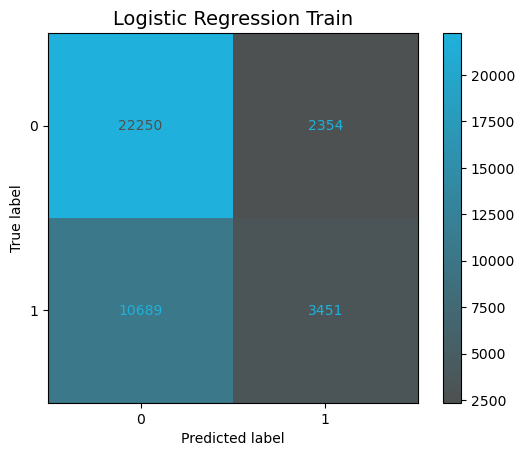

In [46]:
# Confusion matrix display
confusion_matrix(y_train,y_pred)
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,cmap=custom_cmap)
plt.title('Logistic Regression Train',fontsize=14)
plt.show()

**VALIDATION**

In [47]:
# Classification report
y_pred = lr.predict(X_val_scaled_lr)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74      6160
           1       0.61      0.34      0.44      4209

    accuracy                           0.65     10369
   macro avg       0.63      0.60      0.59     10369
weighted avg       0.64      0.65      0.62     10369



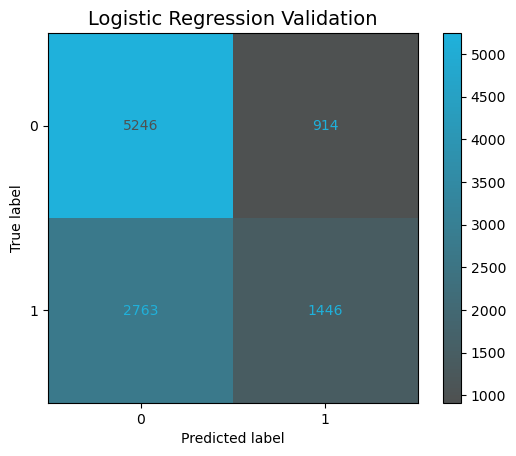

In [48]:
# Confusion matrix display
confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay.from_predictions(y_val,y_pred,cmap=custom_cmap)
plt.title('Logistic Regression Validation',fontsize=14)
plt.show()

**OUT OF TIME**

In [49]:
# Classification report
y_pred = lr.predict(X_oot_scaled_lr)
print(classification_report(y_oot,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.93      0.73      3138
           1       0.69      0.21      0.32      2418

    accuracy                           0.61      5556
   macro avg       0.65      0.57      0.53      5556
weighted avg       0.64      0.61      0.55      5556



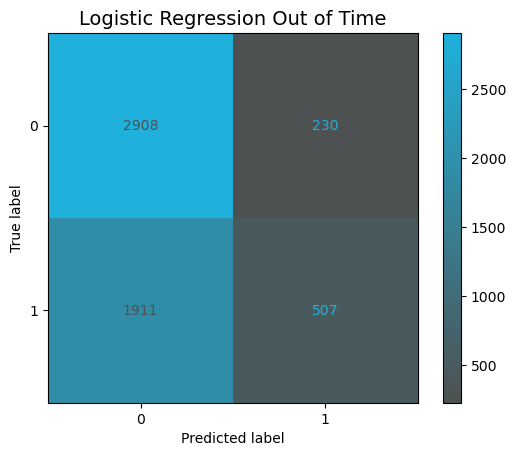

In [50]:
# Confusion matrix display
confusion_matrix(y_oot,y_pred)
ConfusionMatrixDisplay.from_predictions(y_oot,y_pred,cmap=custom_cmap)
plt.title('Logistic Regression Out of Time',fontsize=14)
plt.show()

### *Random Forest*

**TRAIN**

In [51]:
# Classification report
y_pred = rf.predict(X_train_scaled_rf)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     24604
           1       0.87      0.60      0.71     14140

    accuracy                           0.82     38744
   macro avg       0.84      0.78      0.79     38744
weighted avg       0.83      0.82      0.81     38744



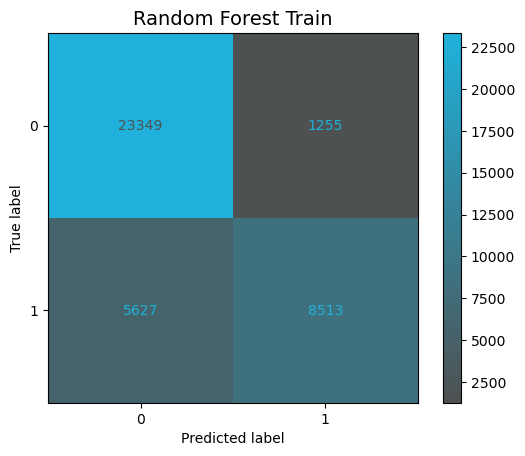

In [52]:
# Confusion matrix display
confusion_matrix(y_train,y_pred)
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,cmap=custom_cmap)
plt.title('Random Forest Train',fontsize=14)
plt.show()

**VALIDATION**

In [53]:
# Classification report
y_pred = rf.predict(X_val_scaled_rf)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      6160
           1       0.56      0.47      0.51      4209

    accuracy                           0.64     10369
   macro avg       0.62      0.61      0.61     10369
weighted avg       0.63      0.64      0.63     10369



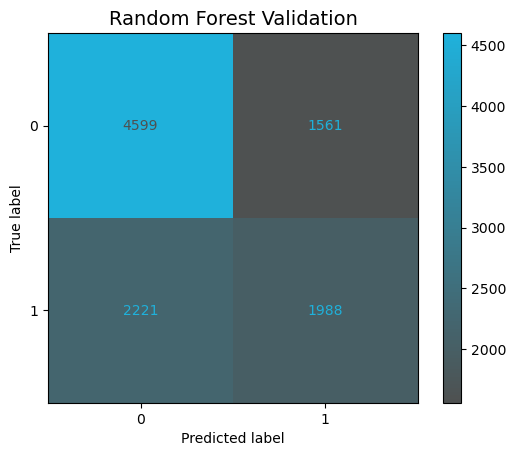

In [54]:
# Confusion matrix display
confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay.from_predictions(y_val,y_pred,cmap=custom_cmap)
plt.title('Random Forest Validation',fontsize=14)
plt.show()

**OUT OF TIME**

In [55]:
# Classification report
y_pred = rf.predict(X_oot_scaled_rf)
print(classification_report(y_oot,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71      3138
           1       0.62      0.35      0.45      2418

    accuracy                           0.62      5556
   macro avg       0.62      0.59      0.58      5556
weighted avg       0.62      0.62      0.60      5556



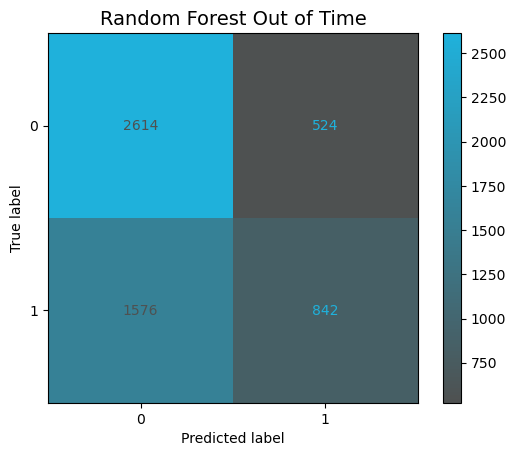

In [56]:
# Confusion matrix display
confusion_matrix(y_oot,y_pred)
ConfusionMatrixDisplay.from_predictions(y_oot,y_pred,cmap=custom_cmap)
plt.title('Random Forest Out of Time',fontsize=14)
plt.show()

### *Gradient Boosting*

**TRAIN**

In [57]:
# Classification report
y_pred = gb.predict(X_train_scaled_gb)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.52      0.61     24604
           1       0.45      0.67      0.53     14140

    accuracy                           0.58     38744
   macro avg       0.59      0.60      0.57     38744
weighted avg       0.63      0.58      0.58     38744



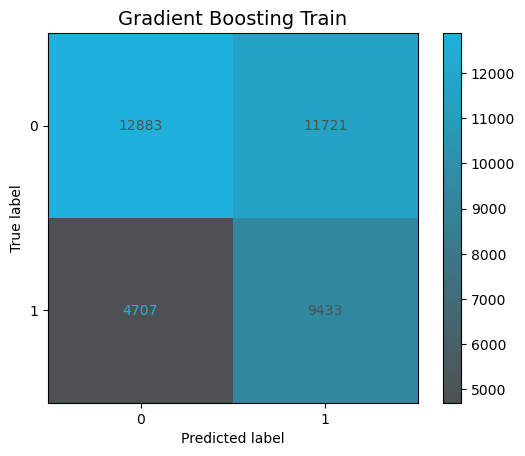

In [58]:
# Confusion matrix display
confusion_matrix(y_train,y_pred)
ConfusionMatrixDisplay.from_predictions(y_train,y_pred,cmap=custom_cmap)
plt.title('Gradient Boosting Train',fontsize=14)
plt.show()

**VALIDATION**

In [59]:
# Classification report
y_pred = gb.predict(X_val_scaled_gb)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.46      0.56      6160
           1       0.49      0.75      0.59      4209

    accuracy                           0.58     10369
   macro avg       0.61      0.60      0.58     10369
weighted avg       0.63      0.58      0.57     10369



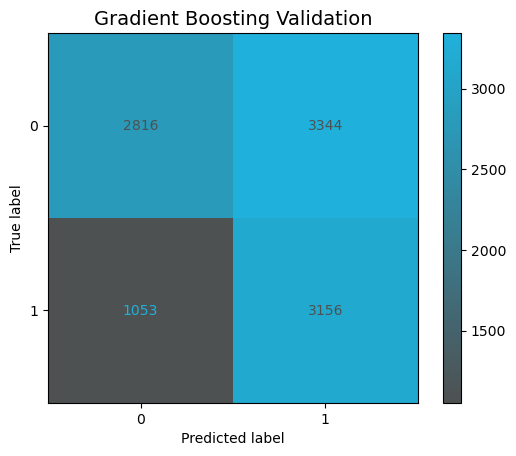

In [60]:
# Confusion matrix display
confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay.from_predictions(y_val,y_pred,cmap=custom_cmap)
plt.title('Gradient Boosting Validation',fontsize=14)
plt.show()

**OUT OF TIME**

In [61]:
# Classification report
y_pred = gb.predict(X_oot_scaled_gb)
print(classification_report(y_oot,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.49      0.57      3138
           1       0.51      0.68      0.58      2418

    accuracy                           0.58      5556
   macro avg       0.59      0.59      0.58      5556
weighted avg       0.60      0.58      0.57      5556



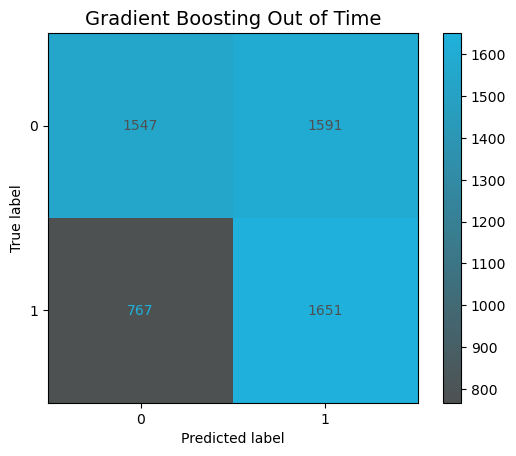

In [62]:
# Confusion matrix display
confusion_matrix(y_oot,y_pred)
ConfusionMatrixDisplay.from_predictions(y_oot,y_pred,cmap=custom_cmap)
plt.title('Gradient Boosting Out of Time',fontsize=14)
plt.show()

## Feature Importance

Next, we will plot the feature importances for each model.

### *Logistic Regression*

C:\Users\seanm\AppData\Local\Temp\ipykernel_20984\2963387850.py:33: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



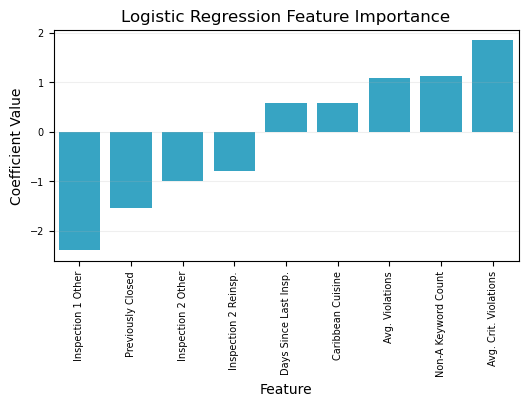

In [69]:
# Use coefficient values to assess feature importance for logistic regression
coefficients = lr.coef_[0]
lr_feat_importance = pd.DataFrame({
    'Feature':X_train_scaled_lr.columns,
    'Coefficient Value':coefficients
}).sort_values(by='Coefficient Value',ascending=True)
# Filter out those with absolute coefficient values < 0.5
most_important = lr_feat_importance[np.abs(lr_feat_importance['Coefficient Value'])>0.5]

# Create the plot
fig,ax = plt.subplots(figsize=(6,3))
sns.barplot(data=most_important,
            x='Feature',
            y='Coefficient Value',
            color='#1fb1db')
plt.title('Logistic Regression Feature Importance')
plt.xticks(rotation=90,fontsize=7)
plt.yticks(fontsize=7)
plt.gca().yaxis.grid(True,alpha=.2)

# Specify custom x tick labels that are more readable
labs = [
    'Inspection 1 Other',
    'Previously Closed',
    'Inspection 2 Other',
    'Inspection 2 Reinsp.',
    'Days Since Last Insp.',
    'Caribbean Cuisine',
    'Avg. Violations',
    'Non-A Keyword Count',
    'Avg. Crit. Violations'
]
ax.set_xticklabels(labs)
plt.show()

### *Random Forest*

C:\Users\seanm\AppData\Local\Temp\ipykernel_20984\1233828932.py:30: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



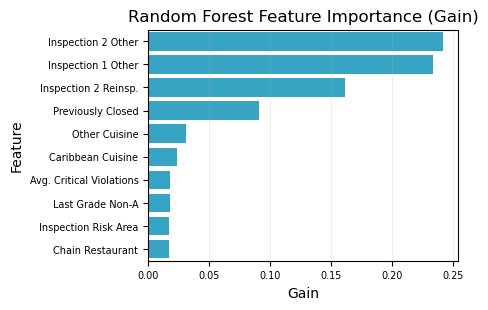

In [70]:
# Plot feature importances for random forest by model gain
importances = rf.feature_importances_
rf_feat_importances = pd.DataFrame({
    'Feature':X_train_scaled_rf.columns,
    'Gain':importances
})
rf_feat_importances = rf_feat_importances.sort_values(by='Gain',ascending=False).head(10)

# Create the plot
fig,ax = plt.subplots(figsize=(4,3))
sns.barplot(data=rf_feat_importances,
            x='Gain',
            y='Feature',
            color='#1fb1db')
plt.title('Random Forest Feature Importance (Gain)')

# Specify more readable y tick labels
labs = [
    'Inspection 2 Other',
    'Inspection 1 Other',
    'Inspection 2 Reinsp.',
    'Previously Closed',
    'Other Cuisine',
    'Caribbean Cuisine',
    'Avg. Critical Violations',
    'Last Grade Non-A',
    'Inspection Risk Area',
    'Chain Restaurant',
]
ax.set_yticklabels(labs)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.gca().xaxis.grid(True,alpha=.2)
plt.show()

### *Gradient Boosting*

C:\Users\seanm\AppData\Local\Temp\ipykernel_20984\2107099318.py:30: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



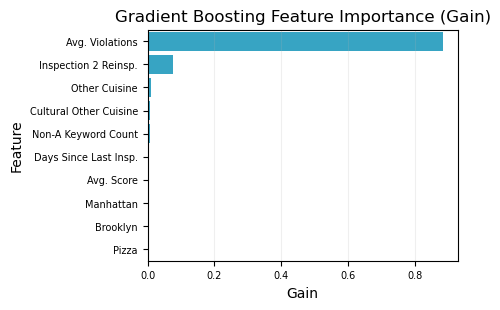

In [74]:
# Plot feature importances for gradient boosting by model gain
gb_importances = gb.feature_importances_
gb_feat_importances = pd.DataFrame({
    'Feature':X_train_scaled_gb.columns,
    'Gain':gb_importances
})
gb_feat_importances = gb_feat_importances.sort_values(by='Gain',ascending=False).head(10)

# Create the plot
fig,ax = plt.subplots(figsize=(4,3))
sns.barplot(data=gb_feat_importances,
            x='Gain',
            y='Feature',
            color='#1fb1db')
plt.title('Gradient Boosting Feature Importance (Gain)')

# Specify more readable y tick labels
labs = [
    'Avg. Violations',
    'Inspection 2 Reinsp.',
    'Other Cuisine',
    'Cultural Other Cuisine',
    'Non-A Keyword Count',
    'Days Since Last Insp.',
    'Avg. Score',
    'Manhattan',
    'Brooklyn',
    'Pizza'
]
ax.set_yticklabels(labs)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.gca().xaxis.grid(True,alpha=.2)
plt.show()

## Error Analysis

Finally, we will see if there are any areas where our gradient boosting model particularly struggled to make accurate predictions.  We will first curate an error analysis dataset using the reserved validation and out-of-time sets from earlier, and then we will briefly look for some sources of error, particularly among our categorical features.

In [66]:
# Build out our error analysis data frame
y_val_pred = gb.predict(X_val_scaled_gb)  # validation predictions
y_oot_pred = gb.predict(X_oot_scaled_gb)  # out-of-time predictions
val = pd.merge(left=X_val_reserve,
               right=y_val,
               left_index=True,
               right_index=True,
               how='inner')
val['prediction'] = y_val_pred
oot = pd.merge(left=X_oot_reserve,
               right=y_oot,
               left_index=True,
               right_index=True,
               how='inner')
oot['prediction'] = y_oot_pred
err = pd.concat([val,oot])
# Identify when our model's predictions are correct
err['correct'] = err['grade'].eq(err['prediction'])
err['correct'] = err['correct']\
    .apply(lambda x: 0 if x==False else 1)
err.head(3)

,is_chain,cuisine_group,closed_past_two_years,avg_violations_past_two_years,violations_last_inspection,last_grade,days_since_last,avg_critical_violations_past_two_years,inspection_risk_area,borough,inspection_type1,inspection_type2,log_avg_score_past_two_years,log_last_score,log_description_keywords_past_two_years,grade,prediction,correct
inspection_id,,,,,,,,,,,,,,,,,,
65918,No,Cultural Other,0.0,4.0,6.0,Not A,92.0,2.0,0.0,Manhattan,Cycle Inspection,Re-inspection,2.833213,3.178054,2.302585,0,0,1
62595,No,Other,0.0,5.5,5.0,Not A,258.0,3.0,0.0,Brooklyn,Cycle Inspection,Initial Inspection,3.433987,3.295837,3.044522,0,1,0
70584,No,Other,0.0,3.0,3.0,A,387.0,1.0,0.0,Brooklyn,Cycle Inspection,Initial Inspection,2.484907,2.484907,2.302585,0,0,1


In [67]:
# For each level in each categorical feature, find the accuracy of our model's predictions
results = {'Feature':[],'Level':[],'Accuracy':[],'Rows':[]}  # storage
cat_feats = list(err.select_dtypes(include='object').columns)
for feat in cat_feats:
    # Obtain the unique levels
    levels = list(err[feat].value_counts().index)
    for level in levels:
        # Subset the df to the specified level
        subset = err[err[feat]==level]
        acc = subset['correct'].mean()  # accuracy
        rows = len(subset)  # count of rows
        # Store the results
        results['Feature'].append(feat)
        results['Level'].append(level)
        results['Accuracy'].append(acc)
        results['Rows'].append(rows)

# Gather results into a dataframe and sort in ascending order of accuracy
err_results = pd.DataFrame(results)\
    .sort_values(by='Accuracy',ascending=True)\
        .reset_index(drop=True)

In [68]:
# Examine the results
err_results

,Feature,Level,Accuracy,Rows
0,cuisine_group,Italian,0.492473,465
1,cuisine_group,Mexican,0.515966,595
2,cuisine_group,American,0.523928,2403
3,cuisine_group,Japanese,0.531083,563
4,cuisine_group,Pizza,0.532120,934
5,is_chain,No,0.562467,11270
6,borough,Brooklyn,0.567034,3901
7,inspection_type2,Re-inspection,0.567054,5421
8,borough,Bronx,0.567419,1639
9,borough,Staten Island,0.571739,460
